In [5]:
import pandas as pd
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataframe = pd.read_csv("Amazon_review.csv")
dataframe.head()

,Unnamed: 0,review,sentiment
0,1959029,I just adopted a chocolate lab who loves to sn...,1
1,971879,Watched it and wasn't very impressed. It was t...,0
2,44681,"By 1967, enough was enough with the light fluf...",0
3,793119,I was interested in what all the hype was abou...,0
4,2921599,I expected a well written book (as someone rec...,0


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100800 entries, 0 to 100799
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  100800 non-null  int64 
 1   review      100800 non-null  object
 2   sentiment   100800 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


Text(0.5, 1.0, 'Number of negative and positive messages')

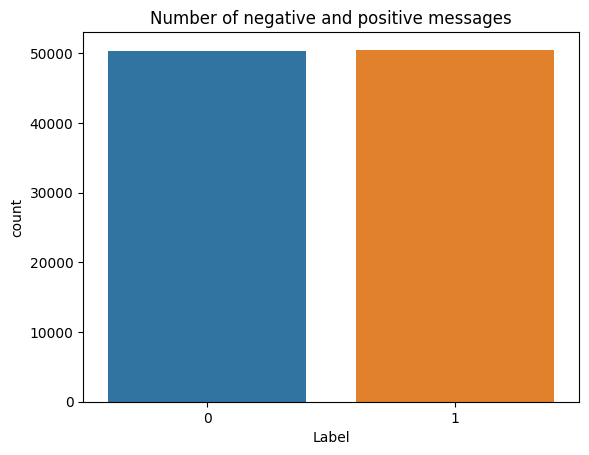

In [6]:
sns.countplot(x=dataframe.sentiment)
plt.xlabel('Label')
plt.title('Number of negative and positive messages')

In [7]:
dataframe = dataframe.drop_duplicates(subset=['review'], keep='first')

In [8]:
len(dataframe['review']), dataframe.review.str.len().max()

(100796, 1008)

In [9]:
reviews = list(dataframe.review)
sentiment = list(dataframe.sentiment)

In [10]:
limit = 15000
reviews = reviews[:limit]
sentiment = sentiment[:limit]

In [11]:
training_size = int(limit * 0.8)
training_sentences = reviews[0:training_size]
testing_sentences = reviews[training_size:]
training_labels = sentiment[0:training_size]
testing_labels = sentiment[training_size:]

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

vocab_size = 20000
embedding_dim = 64
max_length = 100

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [14]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Визначення моделі
model = Sequential()

# Додавання вбудовувального шару

model.add(Embedding(vocab_size, 128))

# Додавання двонапрямленого LSTM
model.add(Bidirectional(LSTM(units=128, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, activation='tanh')))

# Додавання Dense шарів
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
# Вихідний шар
model.add(Dense(units=1, activation='sigmoid'))

# Компіляція моделі
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [20]:
num_epochs = 5
history = model.fit(training_padded, training_labels, epochs=num_epochs,  batch_size=256, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/5
47/47 [==============================] - 164s 3s/step - loss: 0.6923 - accuracy: 0.5076 - val_loss: 0.6663 - val_accuracy: 0.6003
Epoch 2/5
47/47 [==============================] - 156s 3s/step - loss: 0.5911 - accuracy: 0.6998 - val_loss: 0.4573 - val_accuracy: 0.7927
Epoch 3/5
47/47 [==============================] - 145s 3s/step - loss: 0.3846 - accuracy: 0.8597 - val_loss: 0.4106 - val_accuracy: 0.8237
Epoch 4/5
47/47 [==============================] - 153s 3s/step - loss: 0.2427 - accuracy: 0.9270 - val_loss: 0.5277 - val_accuracy: 0.8260
Epoch 5/5
47/47 [==============================] - 153s 3s/step - loss: 0.1443 - accuracy: 0.9647 - val_loss: 0.6312 - val_accuracy: 0.8183


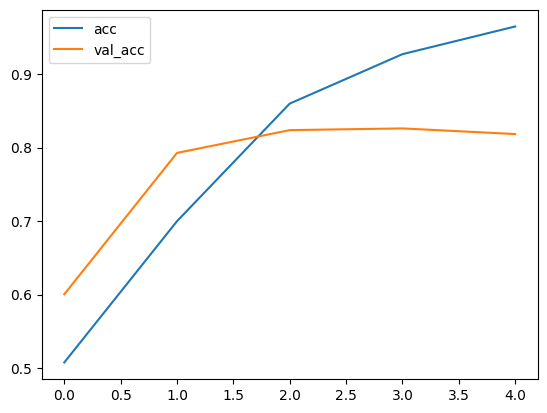

In [21]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

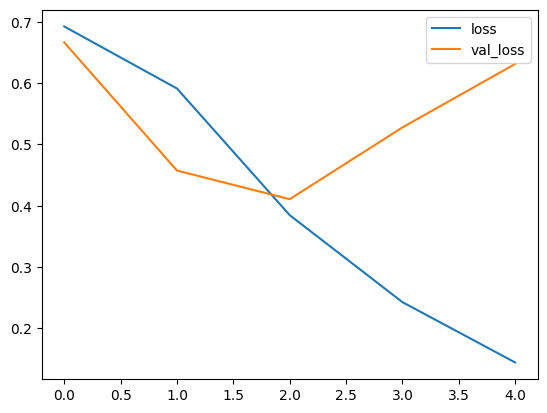

In [22]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

94/94 [==============================] - 23s 242ms/step


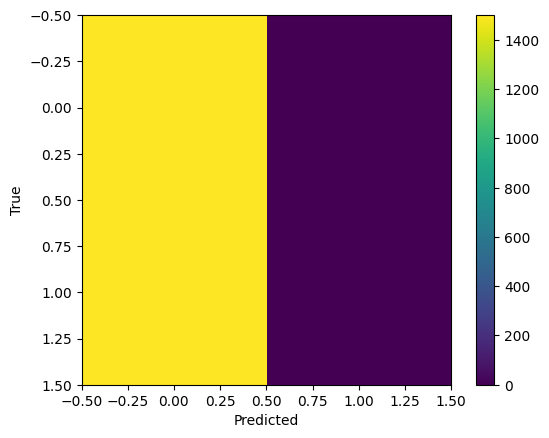

In [27]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(testing_padded)

true_labels = testing_labels

conf_matrix = confusion_matrix(true_labels, predictions.argmax(axis=1))

plt.imshow(conf_matrix, cmap='viridis')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()